# Setup

In [ ]:
# %pip install pymysql
# %pip install sshtunnel
# %pip install pandas

In [1]:
import pymysql
from sshtunnel import SSHTunnelForwarder
import paramiko
from os.path import expanduser
import pandas as pd

In [2]:
import numpy as np

In [3]:
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

In [4]:
home = expanduser('~')
mypkey = paramiko.RSAKey.from_private_key_file( home + "/.ssh/id_rsa")

sql_hostname = '127.0.0.1'
sql_username = 'readonly'
sql_password = None
sql_main_database = 'ML3_mirror'
sql_port = 3306
ssh_host = 'flagon.cs.umn.edu'
ssh_user = 'kanna128'
ssh_port = 22
sql_ip = '1.1.1.1.1'

def SSH_connection(query):
  with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_pkey=mypkey,
        remote_bind_address=(sql_hostname, sql_port)) as tunnel:
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                            passwd=sql_password, db=sql_main_database,
                            port=tunnel.local_bind_port)
    print('connection done')
    df_result = pd.read_sql_query(query,conn)
  
  return df_result

# Description

In [22]:
# choose users with the same firstLogin day -- e.g. all users who first logged in on 2016-04-01
# choose a timeframe for observation (what is a good range? why? | 7 months-1 year | LONGER IS BETTER) -- e.g. from 2016-04-01 to 2017-04-01 | is this enough time to get fair results?
# observe where users perform their first and last recommender change wrt the chosen time period
# observe intermediary actions on a monthly basis -- actions summary for each month/ each quarter during the observation period | per quarter | per session makes the most sense
# this analysis can help answer 'what do users experiment with towards the beginning of their use of MovieLens versus 7 months into using the platform?'
# 'are there noticeable patterns in actions leading to a recommender change?'
# can be extended to different time periods and different firstLogin days | results can be compared for such time periods

# Queries

query_min

In [10]:
query_min = ''' SELECT la.userId, la.action, MIN(la.tstamp) as frecchange FROM ML3_mirror.log_action la INNER JOIN ML3_mirror.user_data ud
                ON ud.userId=la.userId WHERE ud.firstLogin<'2020-12-01' AND ud.firstLogin>='2018-12-01' 
                AND la.tstamp>='2020-11-04' AND la.tstamp<'2021-11-05' AND la.action='recommender-change' GROUP BY la.userId'''
first_rec_change = SSH_connection(query_min)
first_rec_change.head()

connection done


,userId,action,frecchange
0,330960,recommender-change,2020-12-16 15:00:35
1,330967,recommender-change,2021-05-06 00:15:41
2,331018,recommender-change,2020-12-26 07:42:58
3,331067,recommender-change,2021-04-02 14:21:44
4,331100,recommender-change,2020-12-30 23:17:29


In [9]:
query_flog = ''' SELECT la.userId, la.action, MIN(la.tstamp) as flog FROM ML3_mirror.log_action la INNER JOIN ML3_mirror.user_data ud
                 ON ud.userId=la.userId WHERE ud.firstLogin<'2020-12-01' AND ud.firstLogin>='2018-12-01' 
                 AND la.tstamp>='2020-11-04' AND la.tstamp<'2021-11-05' GROUP BY la.userId '''
first_logs = SSH_connection(query_flog)
first_logs.head()

#1m 5.8s

connection done


,userId,action,flog
0,330873,pageview,2020-11-14 19:30:55
1,330888,rating,2021-04-02 22:13:29
2,330903,user-list,2020-12-18 13:31:23
3,330960,pageview,2020-12-16 13:01:48
4,330967,rating,2021-05-06 00:06:07


query_max

In [ ]:
query_max = ''' SELECT la.userId, la.action, MAX(la.tstamp) FROM ML3_mirror.log_action la INNER JOIN ML3_mirror.user_data ud
                ON ud.userId=la.userId WHERE ud.firstLogin<'2015-12-01' AND ud.firstLogin>='2013-12-01' 
                AND la.tstamp>='2015-11-04' AND la.tstamp<'2016-11-05' AND la.action='recommender-change' GROUP BY la.userId '''
last_rec_change = SSH_connection(query_max)
last_rec_change.head()

In [12]:
print("flogs: ", first_logs.shape[0])
print("frec: ", first_rec_change.shape[0])

flogs:  4641
frec:  2245


# Analysis

histogram: frecchange

shape:  2245
0.0
8694.851388888888


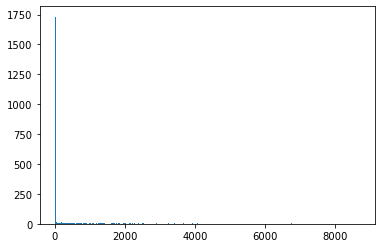

0.7572383073496659


In [24]:
diffs_dict = first_rec_change.set_index('userId').to_dict()['frecchange']
for index, row in first_logs.iterrows():
    user_id = row['userId']
    if user_id in diffs_dict:
        diff = diffs_dict[user_id] - row['flog']
        diffs_dict[user_id] = (diff.total_seconds()) / 3600 

# k=0
# for key,val in diffs_dict.items():
#     if k<5:
#         print(key,val)
#         k+= 1
#     else:
#         break
print("shape: ", len(diffs_dict))
print(min(diffs_dict.values()))
print(max(diffs_dict.values()))

plt.hist(diffs_dict.values(), bins=350)
plt.show()

print(1700/2245)